In [69]:
%matplotlib inline 
##notebook

# import mpld3
# mpld3.enable_notebook()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from os.path import join, getsize
import co2mpas.datasync as datasync 
from co2mpas.model.physical.engine import co2_emission 
from scipy import interpolate

In [70]:
### import_raw_OBD ###
folder = r'K:\PERSONNEL\Valverde\WLTP RLs GS calculation\Twingo\speed test Twingo'
file = 'Twingo_rpm2000_20171107.xlsx'
infile = join(folder, file)
df_OBD = pd.read_excel(infile, sheetname='Recording_11-07-2017_15-17_09',
                       header=1,skiprows = 0)#,engine = 'python')
df_OBD = df_OBD.drop(df_OBD.index[[0]])
#df_OBD

In [71]:
### import_raw_Dyno ###
folder = r'K:\PERSONNEL\Valverde\WLTP RLs GS calculation\Twingo\speed test Twingo'
file = 'VELA2_07112017_003_NEDC x Marce_HOT_Modal_DIL_RWD-sync_23°C.xls'
infile = join(folder, file)
df_dyno = pd.read_excel(infile,'Data')
#df_dyno

In [72]:
times_dyno = df_dyno['DACtrl_TraceTime\n[sec]']
speed_dyno = df_dyno['DACtrl_ActualSpeed\n[kph]']
times_OBD = df_OBD['Time']
times_OBD = times_OBD/1000
speed_OBD = df_OBD['Vehicle speed sensor']
rpm_OBD = df_OBD['Engine RPM']

In [73]:
### Produce a times vector for currents (DYNO) in 1Hz.
times_1Hz_OBD = np.arange(0,max(times_OBD+1),1)

#print("This is the lenght of the current vector: " + str(l))
print("This is the time period of the OBD: " + str(max(times_OBD)) + " sec")
print("This is the time period of the current vector in 1Hz: " + str(max(times_1Hz_OBD)))

This is the time period of the OBD: 764.24 sec
This is the time period of the current vector in 1Hz: 765.0


In [85]:
### Linear interpolation for the OBD signals.

#load_co2mpas = datasync._get_interp_method('linear')(times_1Hz_OBD, times_load_OBD, load_OBD)
rpm_1Hz_OBD = datasync._get_interp_method('linear')(times_1Hz_OBD, times_OBD, rpm_OBD)
speed_1Hz_OBD = datasync._get_interp_method('linear')(times_1Hz_OBD, times_OBD, speed_OBD)
#temp_co2mpas = datasync._get_interp_method('linear')(times_1Hz_OBD, times_temp_OBD, temp_OBD)

In [87]:
len(speed_1Hz_OBD)


766

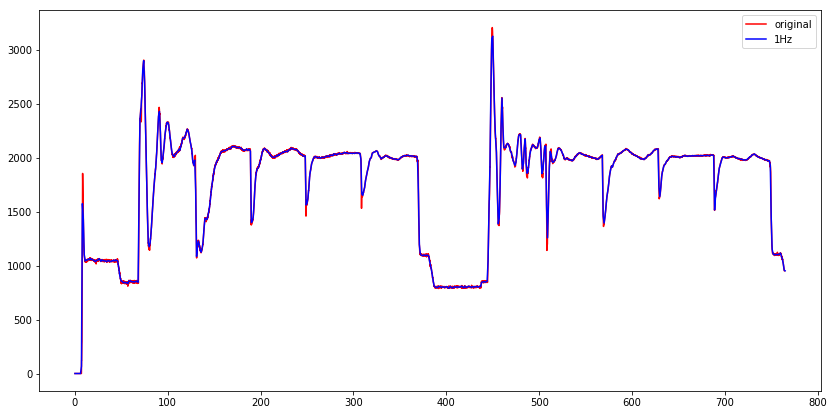

In [88]:
plt.figure(figsize=(14,7))

plt.plot(times_OBD,rpm_OBD, 'r', label='original')
plt.plot(times_1Hz_OBD,rpm_1Hz_OBD, 'b', label='1Hz')
plt.legend()
plt.show()

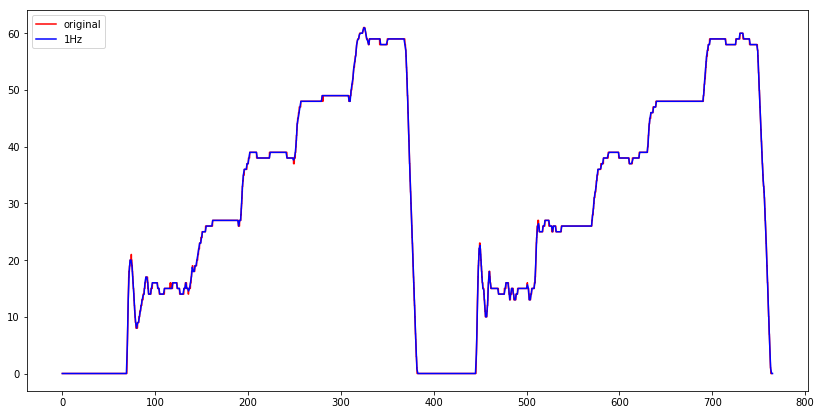

In [90]:
plt.figure(figsize=(14,7))

plt.plot(times_OBD,speed_OBD, 'r', label='original')
plt.plot(times_1Hz_OBD,speed_1Hz_OBD, 'b', label='1Hz')
#plt.plot(wltp_theoretical['times']+83,wltp_theoretical['WLTP'], 'g', label='theoretical')
plt.legend()
plt.show()

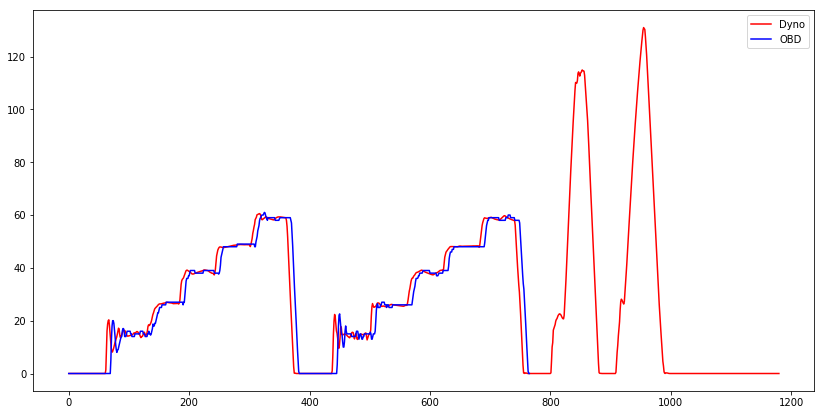

In [91]:
plt.figure(figsize=(14,7))

plt.plot(times_dyno,speed_dyno, 'r', label='Dyno')
plt.plot(times_1Hz_OBD,speed_1Hz_OBD, 'b', label='OBD')
plt.legend()
plt.show()

## Datasync

In [92]:
def synchronization(ref, data):
    f = datasync._yield_synched_tables(ref, data,  x_label='times', 
                                   y_label='velocities', interpolation_method='linear', 
                                   interpolation_methods=None)
    for i in [0,1]:
        a = next(f)
    return a[1]

In [101]:
### Synchronization of OBD signals

### Reference: Theoretical WLTP velocity profile
ref = pd.DataFrame({'times': np.arange(0,1181), 'velocities': speed_dyno })   #wltp_theoretical['WLTP']})

### Signal to be synchronized through Theoretical WLTP velocity profile: OBD + currents
obd = pd.DataFrame({'times':times_1Hz_OBD, 'velocities': speed_1Hz_OBD, 
                    'engine_speeds_out': rpm_1Hz_OBD})

In [102]:
### Final Data
synchronized_data = synchronization(ref,obd)

In [107]:
synchronized_data.tail()

,engine_speeds_out,velocities
1176,951.0,0.0
1177,951.0,0.0
1178,951.0,0.0
1179,951.0,0.0
1180,951.0,0.0


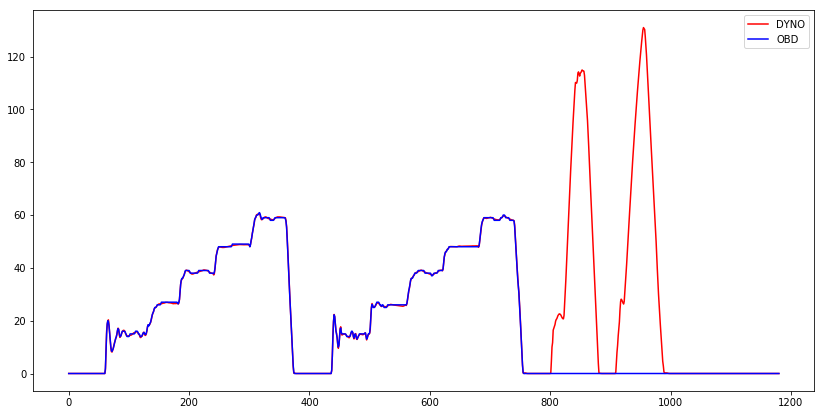

In [106]:
plt.figure(figsize=(14,7))

plt.plot(speed_dyno, 'r', label='DYNO')
plt.plot(synchronized_data['velocities'], 'b', label='OBD')
#plt.plot(wltp_theoretical['times']+83,wltp_theoretical['WLTP'], 'g', label='theoretical')
plt.legend()
plt.show()

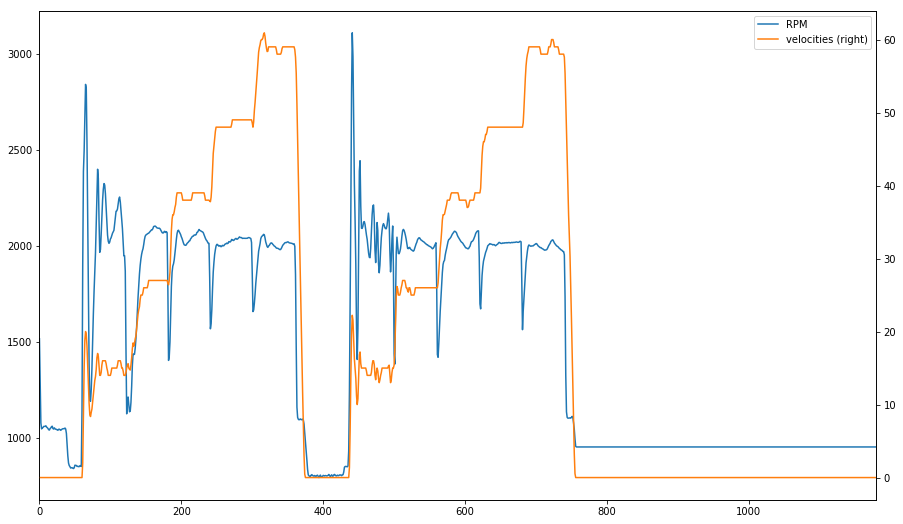

In [113]:
synchronized_data['engine_speeds_out'].plot(label="RPM", legend=True, figsize=(15,9))
synchronized_data['velocities'].plot(secondary_y=True, label="velocities", legend=True)

## To excel

In [114]:
# ### Concentrated DATA ##
from pandas import ExcelWriter
# folder = r'C:\Users\komnodi\Desktop\Fiat_Panda\20170407_PANDA_again\07.WLTC_COLD\Run1\Data'
file = r'K:\PERSONNEL\Valverde\WLTP RLs GS calculation\Twingo\speed test Twingo/sync_obd_dyno.xlsx'
# infile = join(folder, file)
writer = ExcelWriter(file)
synchronized_data.to_excel(writer,'Data')
writer.save()